In [37]:
# 1. Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

import mediapipe as mp
import cv2
from sklearn.model_selection import GridSearchCV


# 1.Make code reproducible

In [38]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

In [39]:
set_seeds(42)

# 2.Load the data

In [ ]:
df = pd.read_csv("hand_landmarks_data.csv")

In [ ]:
print("Data shape:", df.shape)
df.head()

Data shape: (25675, 64)


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


# 3.Plotting Sample

In [33]:
def plot_sample(sample_vis):
  for k in range(len(sample_vis)):
    row = sample_vis.iloc[k]

    # Extract x and y
    x = [row[f'x{i}'] for i in range(1,22)]
    y = [row[f'y{i}'] for i in range(1,22)]
    print(len(x))
    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c='blue')

    # Optionally connect in order
    # for i in range(20):
    #     plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color='gray')

    # Invert Y-axis to match image coordinates
    plt.gca().invert_yaxis()

    # plt.title(row["label"])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis("equal")  # Keep aspect ratio square
    plt.show()


21


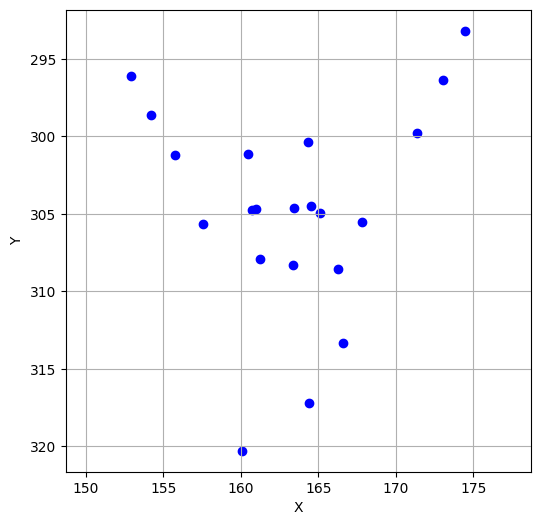

21


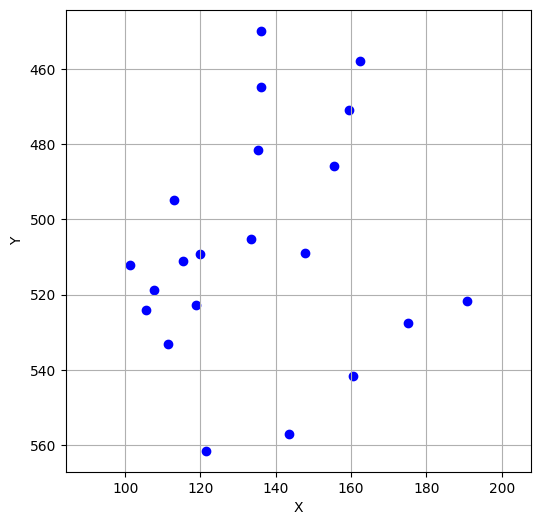

21


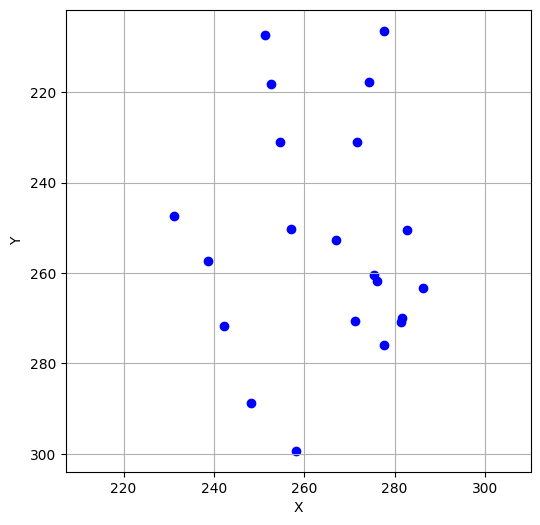

21


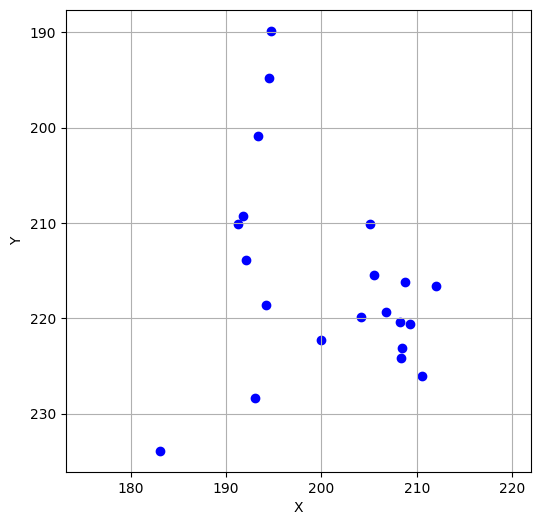

21


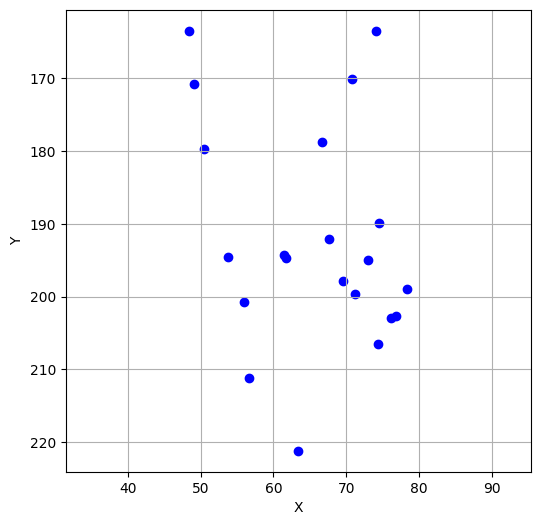

In [ ]:
plot_sample(df.sample(5, random_state=42))

# 4.Exploration

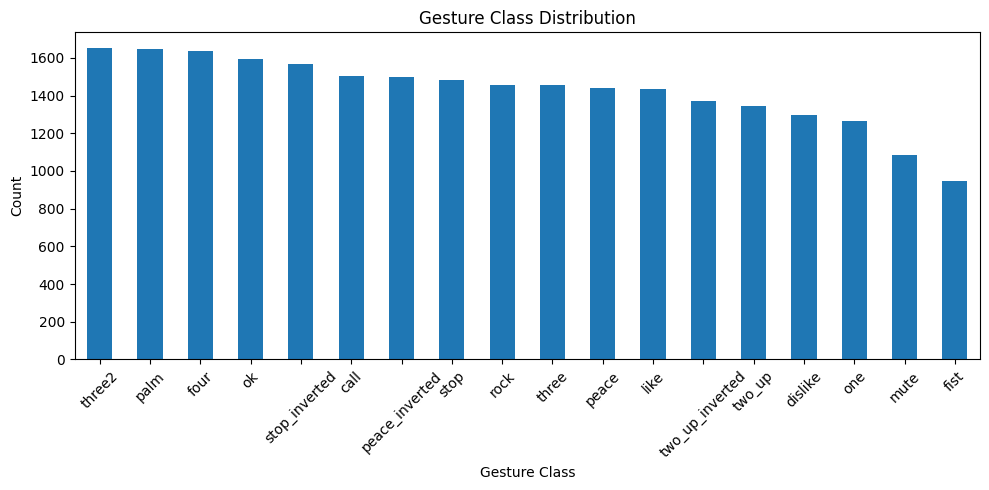

In [22]:
df['label'].value_counts().plot(kind='bar', figsize=(10,5), title='Gesture Class Distribution')
plt.xlabel("Gesture Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Data Almost balanced

# 5.Preprocessing

In [ ]:
labels = df['label']
features = df.drop(columns=['label'])

In [ ]:
# Centering by wrist, and scaling by middle finger tip
def normalize_landmarks(row):
    coords = row.values.reshape(-1, 3)
    wrist = coords[0][:2]  # x, y of wrist
    mid_tip = coords[12][:2]  # x, y of middle finger tip
    scale = np.linalg.norm(mid_tip - wrist)
    coords[:, :2] = (coords[:, :2] - wrist) / (scale + 1e-6)
    return coords.flatten()

In [8]:
X_normalized = features.apply(normalize_landmarks, axis=1, result_type='expand')

In [9]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_normalized)

In [10]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# 6.Modeling

In [ ]:
models_params = {
    "SVM": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    }
}


In [ ]:
def run_grid_search(X_train, y_train, X_test, y_test):

    best_models = {}
    results = {}

    for name, cfg in models_params.items():

        print(f"Grid Search for {name}")

        # I make scoring to be 'accuracy' because my data is balanced and in this case accuracy is appropriate choise.
        grid = GridSearchCV(cfg["model"], cfg["params"], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        
        best_model = grid.best_estimator_
        best_models[name] = best_model

        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc

        print(f"\nBest parameters for {name}: {grid.best_params_}")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))

    return best_models, results


In [27]:
best_models, results = run_grid_search(X_train, y_train, X_test, y_test)

# Select the best performing model
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name} with accuracy {results[best_model_name]:.4f}")


Grid Search for SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9671
                 precision    recall  f1-score   support

           call       1.00      0.99      0.99       287
        dislike       0.97      1.00      0.98       260
           fist       1.00      1.00      1.00       209
           four       0.97      0.97      0.97       325
           like       1.00      1.00      1.00       304
           mute       0.94      0.96      0.95       195
             ok       0.99      0.99      0.99       340
            one       0.97      0.96      0.96       248
           palm       0.97      0.97      0.97       317
          peace       0.90      0.91      0.90       276
 peace_inverted       0.97      0.91      0.94       307
           rock       1.00      0.99      0.99       290
           stop       0.93      0.99      0.96       293
  stop_inverted       0.99      

# 7. Live Testing

In [31]:
# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Normalize the landmarks like in training
def preprocess_landmarks(landmarks):
    coords = np.array(landmarks).reshape(-1, 3)
    wrist = coords[0][:2]
    mid_tip = coords[12][:2]
    scale = np.linalg.norm(mid_tip - wrist)
    coords[:, :2] = (coords[:, :2] - wrist) / (scale + 1e-6)
    return coords.flatten()

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Flip and convert to RGB
    image = cv2.flip(frame, 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                h, w, _ = image.shape
                landmarks.append([lm.x * w, lm.y * h, lm.z])
            processed = preprocess_landmarks(landmarks)
            processed = scaler.transform([processed])
            prediction = best_model.predict(processed)[0]

            # Draw landmarks & prediction
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.putText(image, f'Gesture: {prediction}', (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    cv2.imshow('Hand Gesture Prediction', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [40]:
!pip freeze > requirements.txt